In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix as confmat,classification_report as creport)

In [3]:
from gensim.models.keyedvectors import KeyedVectors

In [4]:
import tensorflow

In [6]:
tensorflow.__version__

'2.1.3'

In [7]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input#, LSTM, Bidirectional
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.preprocessing import sequence ,text
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback

In [8]:
df = pd.read_csv("Emotional-Tone-Dataset.csv")

In [9]:
df.head()

,ID,TWEET,LABEL
0,1,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,2,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,3,كتنا نيله ف حظنا الهباب xD,sadness
3,4,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,5,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none


In [11]:
df.columns

Index(['ID', ' TWEET', ' LABEL'], dtype='object')

In [12]:
df.columns = ['id', 'tweet', 'label']

In [13]:
df.columns

Index(['id', 'tweet', 'label'], dtype='object')

In [32]:
df.drop('id',axis=1,inplace=True)

In [35]:
df.dropna(axis=0,inplace=True)

In [36]:
df.isnull().any().sum()

0

In [37]:
df.head()

,tweet,label
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,كتنا نيله ف حظنا الهباب xD,sadness
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none


In [38]:
df.to_csv('emotion_data.csv')

In [15]:
model_bucket = 'resources-93/word2vec'
model_key = 'cc.ar.300.vec'
model_location = 's3://{}/{}'.format(model_bucket,model_key)

In [16]:
def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path, limit=500000)
    else:
        word_model = KeyedVectors.load(path)
    n_words = len(word_model.index_to_key)
    vocab_dim = word_model[word_model.index_to_key[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index_to_key[i]] = i+1
    return word_model, index_dict, n_words, vocab_dim

In [17]:
# language model
# Don't set "ext" argument in case of using Word2Vec

WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(model_location, ext='vec')

In [18]:
WORD_MODEL

In [19]:
MAX_FEATURES

500000

In [20]:
EMBED_SIZE

300

In [68]:
def split_datasets_2(data_paths, test_size, header=True, seed=42):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, encoding="utf8") as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[1])
                    y.append(temp[2].replace('\n', ''))
    max_length = get_max_length(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
    print('Dataset splited.')
    return x_train, x_test, y_train, y_test, max_length , x , y

In [69]:
def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length

In [70]:
data_paths = ["emotion_data.csv"]
x_train, x_test, y_train, y_test, MAX_TEXT_LENGTH , x , y= split_datasets_2(data_paths, test_size=0.2, seed=42)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))

Dataset splited.
Label categories: ['anger' 'fear' 'joy' 'love' 'none' 'sadness' 'surprise' 'sympathy']


In [71]:
y

['none',
 'anger',
 'sadness',
 'joy',
 'none',
 'surprise',
 'love',
 'sympathy',
 'love',
 'sadness',
 'fear',
 'joy',
 'love',
 'joy',
 'love',
 'none',
 'love',
 'sadness',
 'none',
 'sympathy',
 'sympathy',
 'sympathy',
 'sympathy',
 'anger',
 'none',
 'surprise',
 'sadness',
 'sympathy',
 'surprise',
 'love',
 'sympathy',
 'none',
 'surprise',
 'sympathy',
 'surprise',
 'sadness',
 'joy',
 'anger',
 'joy',
 'joy',
 'fear',
 'love',
 'surprise',
 'fear',
 'sadness',
 'none',
 'fear',
 'sympathy',
 'anger',
 'anger',
 'sympathy',
 'surprise',
 'fear',
 'anger',
 'joy',
 'none',
 'surprise',
 'none',
 'none',
 'love',
 'love',
 'sadness',
 'none',
 'love',
 'joy',
 'sympathy',
 'fear',
 'sympathy',
 'fear',
 'fear',
 'joy',
 'love',
 'surprise',
 'joy',
 'none',
 'fear',
 'surprise',
 'joy',
 'none',
 'anger',
 'fear',
 'surprise',
 'joy',
 'surprise',
 'fear',
 'sympathy',
 'surprise',
 'none',
 'surprise',
 'joy',
 'sympathy',
 'surprise',
 'surprise',
 'anger',
 'sympathy',
 'ang

In [74]:
len(x_train)

8051

In [75]:
def get_train_test(train_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

In [76]:
def class_str_2_ind(x_train, x_test, y_train, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_test = y_encoder.transform(y_test)
    train_y_cat = to_categorical(y_train, len(classes))
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of testing examples: ' + str(len(x_vec_test)))
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

In [77]:
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, 
                                                                            y_train, y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)

Converting data to trainable form...
Number of training examples: 8051
Number of testing examples: 2013


In [78]:
x_train.shape

(8051, 35)

In [80]:
y_train

array([0, 4, 5, ..., 0, 0, 0])

In [81]:
test_cat_y = to_categorical(y_test, len(CLASSES_LIST))

In [87]:
# Sequence length
MAX_TEXT_LENGTH = 35

In [90]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.')        
    return embedding_matrix

In [152]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    :params:
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)

    model = Conv1D(filters=3, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dropout(0.05)(model)
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.05)(model)
    model = Dense(8, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    """
    DOC
    """
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    """
    DOC 
    """
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

In [153]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 35)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 35, 300)           10160100  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 3)             1803      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 17, 3)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 51)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 51)                0         
_________________________________________________________________
dense

In [154]:
from time import time
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y,
                               batch_size=16, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 8051 samples, validate on 2013 samples
Epoch 1/20
7952/8051 [============================>.] - ETA: 0s - loss: 1.8549 - accuracy: 0.2935
Testing loss: 1.6221008677418647, acc: 0.3800297975540161

8051/8051 [==============================] - 5s 605us/sample - loss: 1.8511 - accuracy: 0.2946 - val_loss: 1.6221 - val_accuracy: 0.3800
Epoch 2/20
8048/8051 [============================>.] - ETA: 0s - loss: 1.4780 - accuracy: 0.4467
Testing loss: 1.4930160825547447, acc: 0.4376552402973175

8051/8051 [==============================] - 4s 469us/sample - loss: 1.4783 - accuracy: 0.4465 - val_loss: 1.4930 - val_accuracy: 0.4377
Epoch 3/20
7952/8051 [============================>.] - ETA: 0s - loss: 1.3746 - accuracy: 0.4901
Testing loss: 1.4082368671509145, acc: 0.47391951084136963

8051/8051 [==============================] - 4s 465us/sample - loss: 1.3733 - accuracy: 0.4911 - val_loss: 1.4082 - val_accuracy: 0.4739
Epoch 4/20
7968/8051 [============================>.] - ETA: 0s - los

In [155]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y)

2013/2013 [==============================] - 0s 91us/sample - loss: 1.3282 - accuracy: 0.5296


[1.328248864551474, 0.5295579]

In [156]:
y_pred = np.argmax(model.predict(x_test[:, :MAX_TEXT_LENGTH]), axis=1)
# y_pred = np_utils.to_categorical(np.argmax(y_pred, axis=1), len(CLASSES_LIST))

cm = confmat(np.argmax(test_cat_y, axis=1), y_pred)

print("Confusion Matrix :\n\n {}\n".format(cm))
print(creport(np.argmax(test_cat_y, axis=1), y_pred))

Confusion Matrix :

 [[162   9  24   6  29  21  31  13]
 [ 10 194   1   2   5  16   9   5]
 [ 10   0 123  25  58  25  19   4]
 [ 14   2  60 110   3  24   0  21]
 [ 22   1  29   1 178   9  37   2]
 [ 41   5  26  28  47  78  24  16]
 [ 23   7  29   2  67  26  64   5]
 [  8   2  15  10   1  18   0 157]]

              precision    recall  f1-score   support

           0       0.56      0.55      0.55       295
           1       0.88      0.80      0.84       242
           2       0.40      0.47      0.43       264
           3       0.60      0.47      0.53       234
           4       0.46      0.64      0.53       279
           5       0.36      0.29      0.32       265
           6       0.35      0.29      0.31       223
           7       0.70      0.74      0.72       211

    accuracy                           0.53      2013
   macro avg       0.54      0.53      0.53      2013
weighted avg       0.53      0.53      0.53      2013



In [157]:
n = np.argmin(history.history['val_loss'])

print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on test : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on test : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Accuracy on train : 59.74 %
Accuracy on test : 52.91 %
Loss on train : 109.32
Loss on test : 132.3


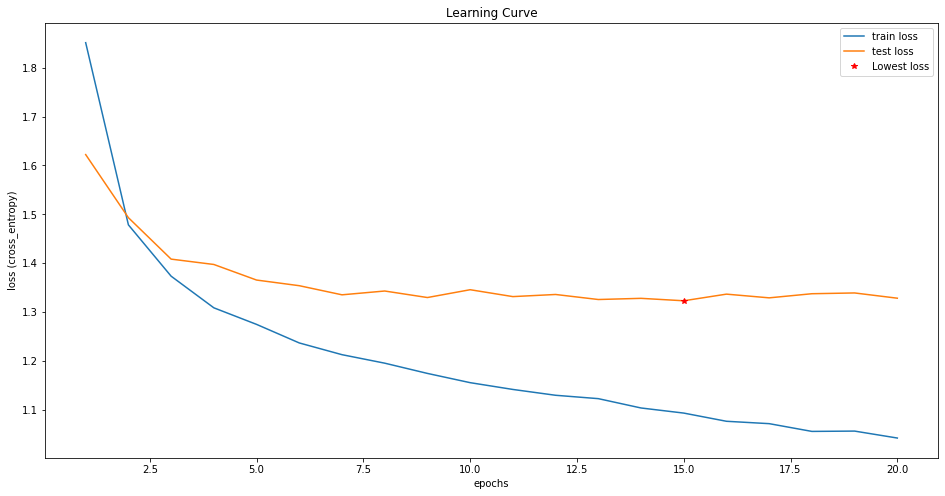

In [158]:
plt.figure("Loss Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="test loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
#plt.savefig("./img/loss_500_2000_sg_true_40.png")
plt.show();

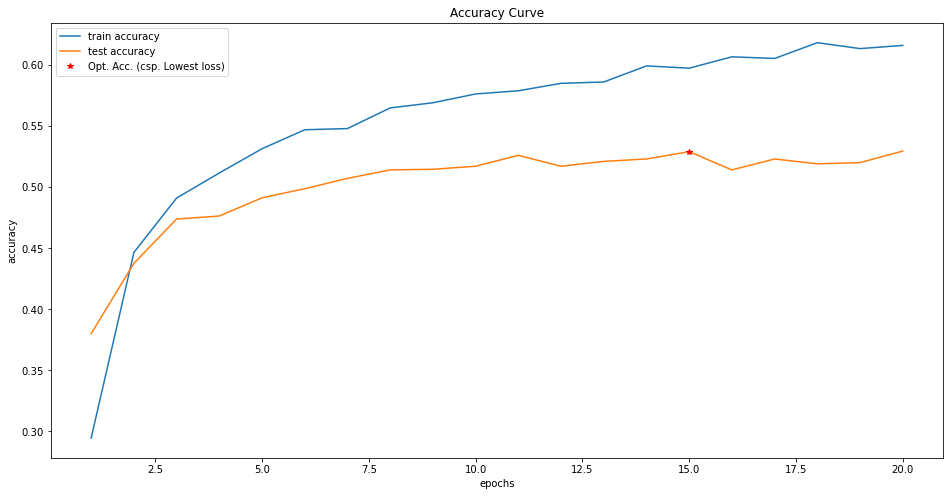

In [159]:
plt.figure("Accuracy Plot", figsize=(16, 8))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="test accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
#plt.savefig("./img/acc_500_2000_sg_true_40.png")
plt.show()

In [82]:
## # Save the weights
!mkdir -p checkpoints
model.save_weights('./checkpoints/my_checkpoint')

In [83]:
model.save('./checkpoints/arabic_text_classification_model.h5')